In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

In [69]:
basedir = '/media/guille/DADES/DADES/RubenDoste/ZhejiangDatabase/'

P = sak.load_data(os.path.join(basedir,'P.csv'))
QRS = sak.load_data(os.path.join(basedir,'QRS.csv'))
T = sak.load_data(os.path.join(basedir,'T.csv'))

100%|██████████| 336/336 [04:01<00:00,  1.39it/s]


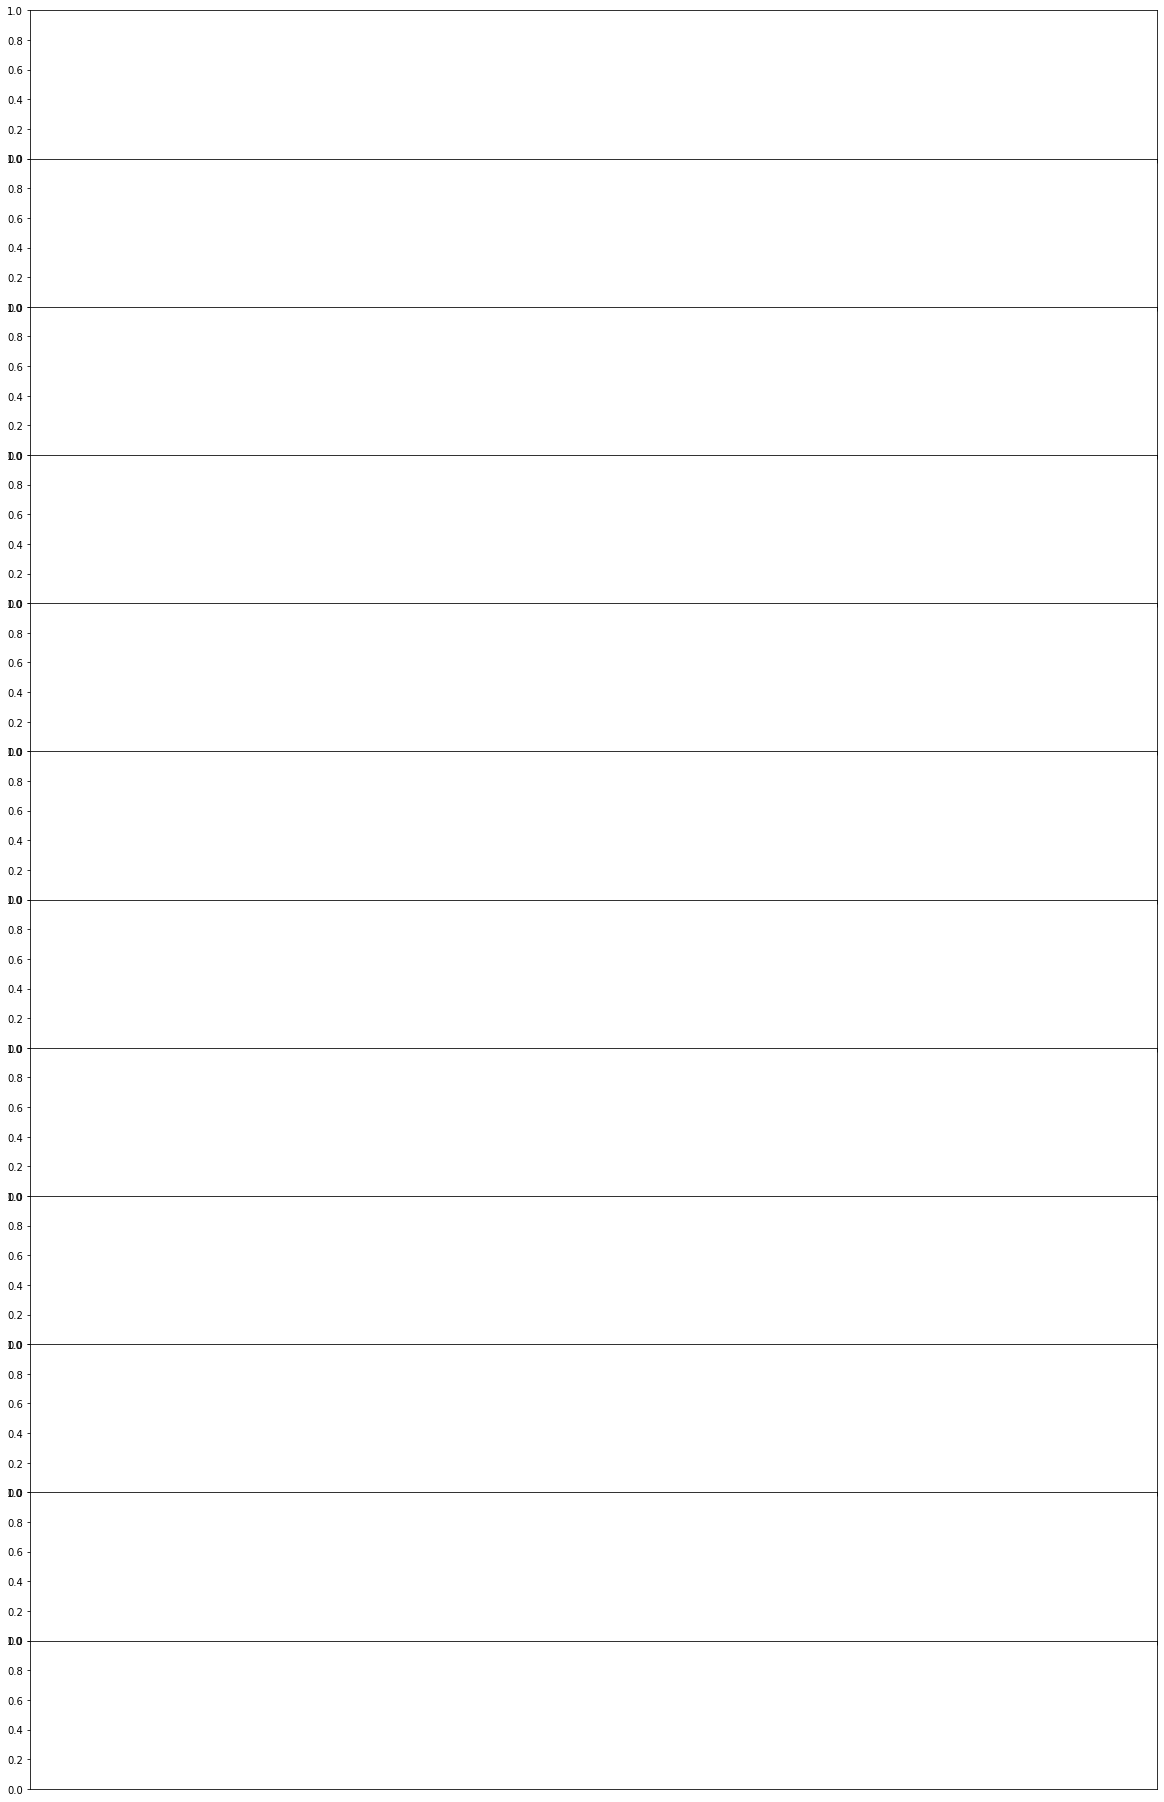

In [88]:
target_width = 2500
down_factor = 4
listfiles = glob.glob(os.path.join(basedir,'PVCVTRawECGData','*.csv'))

# Crop QRS waves?
crop_qrs = True

# Instantiate figure
fig,ax = plt.subplots(nrows=12,figsize=(16,25),sharex=True)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

for i,file in enumerate(tqdm.tqdm(listfiles)):
    # Get UID
    root,fname = os.path.split(file)
    fname,ext = os.path.splitext(fname)
    
    # Read file
    try:
        signal = pd.read_csv(os.path.join(basedir,'PVCVTECGData',f'{fname}.csv'))
    except:
        continue
    
    # Downsample signal to 250Hz (faster loading, etc)
    signal = sp.signal.decimate(signal,down_factor,axis=0)

    # Filter baseline wander
    signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.75/250., 'high'),signal.T).T
    
    # Retrieve segmentation
    try:
        pon,poff =       P[f"{fname}###I"][::2]//down_factor,  P[f"{fname}###I"][1::2]//down_factor
        qrson,qrsoff = QRS[f"{fname}###I"][::2]//down_factor,QRS[f"{fname}###I"][1::2]//down_factor
        ton,toff =       T[f"{fname}###I"][::2]//down_factor,  T[f"{fname}###I"][1::2]//down_factor
    except:
        continue
    
    # Get x limits
    minimum = min(np.concatenate([pon,poff,qrson,qrsoff,ton,toff]))
    maximum = max(np.concatenate([pon,poff,qrson,qrsoff,ton,toff]))
    width = maximum-minimum
    diff = (target_width-width)//2
    if diff < 50:
        diff = 50
        
    [ax[j].plot(signal[:,j]) for j in range(12)]
    [[ax[j].axvspan(on,off,color='red',alpha=0.1) for on,off in zip(pon,poff)] for j in range(12)]
    [[ax[j].axvspan(on,off,color='green',alpha=0.1) for on,off in zip(qrson,qrsoff)] for j in range(12)]
    [[ax[j].axvspan(on,off,color='magenta',alpha=0.1) for on,off in zip(ton,toff)] for j in range(12)]
    [ax[j].set_xticks([]) for j in range(12)]
    [ax[j].set_yticks([]) for j in range(12)]
    [ax[j].set_xlim([minimum-diff,maximum+diff]) for j in range(12)]
    if crop_qrs:
        for j in range(12):
            max_t = np.max([np.max(signal[on:off,j]) for on,off in zip(ton,toff)])
            min_t = np.min([np.min(signal[on:off,j]) for on,off in zip(ton,toff)])
            ax[j].set_ylim([min_t-500,max_t+500])
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    if crop_qrs:
        fig.savefig(os.path.join(basedir,'Figures','ManualTWave',f'{fname}.png'))
    else:
        fig.savefig(os.path.join(basedir,'Figures','ManualDelineation',f'{fname}.png'))
#     if fname == '1011746':
#         adjktha
    [ax[j].clear() for j in range(12)]
